<a href="https://colab.research.google.com/github/syadri/Wind-Power-Multivariate-Time-Series-Forecasting/blob/main/5_Epoch_Multivariate_LSTM_30_mins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
%%capture
!wget 'https://s3.us-east-1.wasabisys.com/datasets-njead/T1.csv (1).zip' -O 'T1.zip'


!unzip /content/T1.zip

In [3]:
data = pd.read_csv('/content/T1.csv')

data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [4]:


# Load the dataset from a CSV file
df = pd.read_csv('/content/T1.csv')

# Convert the 'Date/Time' column to a datetime object and set it as the index
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')
df.set_index('Date/Time', inplace=True)

# Select the columns to use as features and normalize the data
features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# Create a function to generate a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Adapted from: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{df.columns[j]}(t-{i})' for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{df.columns[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{df.columns[j]}(t+{i})' for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Generate the supervised learning dataset
timesteps = 3
df_supervised = series_to_supervised(df_scaled, n_in=timesteps, n_out=1)

# Split the dataset into training and testing sets
train_size = int(len(df_supervised) * 0.80)
train, test = df_supervised[:train_size], df_supervised[train_size:]

# Reshape the training and testing sets for LSTM input
X_train, y_train = train.iloc[:, :-len(features)], train.iloc[:, -len(features):]
X_test, y_test = test.iloc[:, :-len(features)], test.iloc[:, -len(features):]
X_train = X_train.values.reshape((X_train.shape[0], timesteps, len(features)))
X_test = X_test.values.reshape((X_test.shape[0], timesteps, len(features)))

# Define the model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(len(features)))
model.compile(loss='mse', optimizer='adam')

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), verbose=2, shuffle=False)


Epoch 1/5
2527/2527 - 27s - loss: 0.0118 - val_loss: 0.0072 - 27s/epoch - 11ms/step
Epoch 2/5
2527/2527 - 10s - loss: 0.0065 - val_loss: 0.0064 - 10s/epoch - 4ms/step
Epoch 3/5
2527/2527 - 11s - loss: 0.0060 - val_loss: 0.0064 - 11s/epoch - 4ms/step
Epoch 4/5
2527/2527 - 10s - loss: 0.0059 - val_loss: 0.0063 - 10s/epoch - 4ms/step
Epoch 5/5
2527/2527 - 10s - loss: 0.0059 - val_loss: 0.0062 - 10s/epoch - 4ms/step


316/316 [==============================] - 1s 2ms/step
RMSE for LV ActivePower (kW): 273.524
RMSE for Wind Speed (m/s): 1.000
RMSE for Theoretical_Power_Curve (KWh): 304.866
RMSE for Wind Direction (°): 36.770


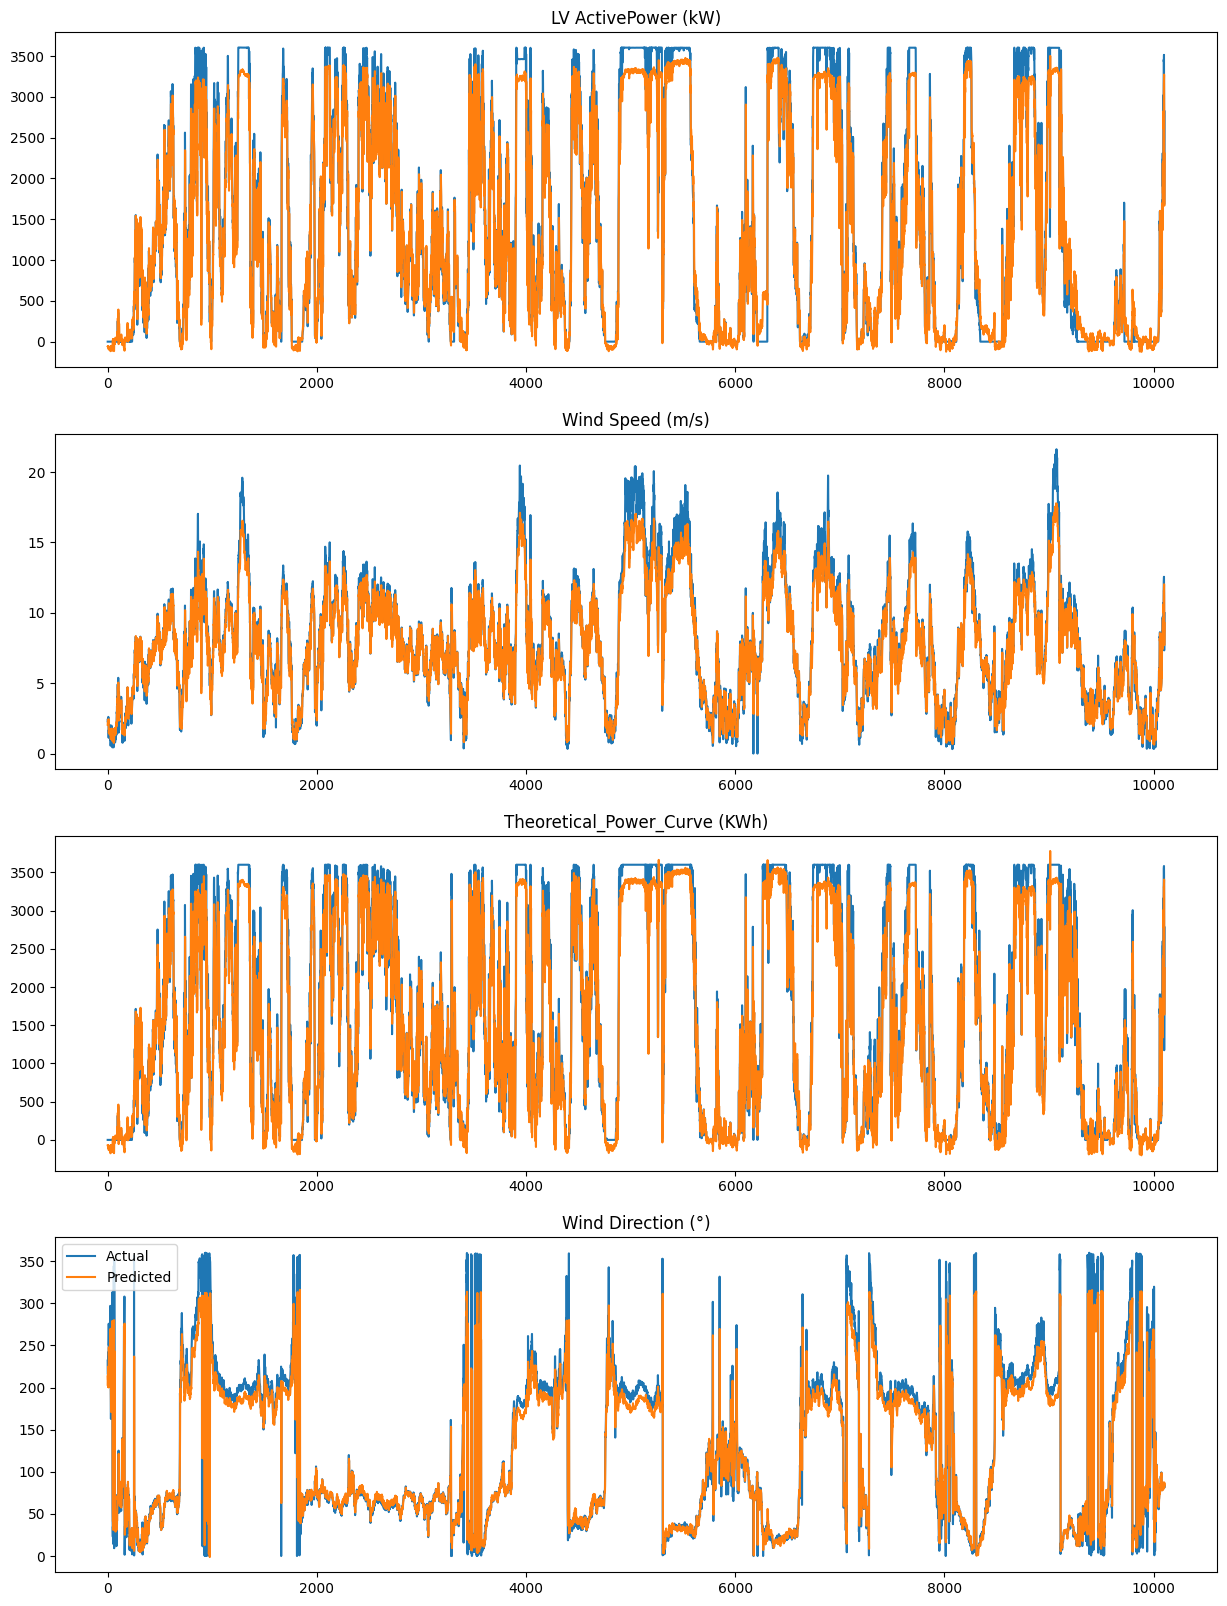

In [15]:
# # Evaluate the model on the testing data
# _, mse = model.evaluate(X_test, y_test, verbose=0)
# print(f'MSE: {mse:.3f}')

# Make predictions on the testing data
yhat = model.predict(X_test)

# Invert the scaling of the predicted and actual values
yhat_inv = scaler.inverse_transform(yhat)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate the RMSE for each feature
rmse = np.sqrt(np.mean((yhat_inv - y_test_inv)**2, axis=0))
for i, name in enumerate(features):
    print(f'RMSE for {name}: {rmse[i]:.3f}')

# Plot the predicted and actual values for each feature
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 20))
for i, name in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(y_test_inv[:, i], label='Actual')
    plt.plot(yhat_inv[:, i], label='Predicted')
    plt.title(name)
plt.legend()
plt.show()


In [6]:
results = pd.DataFrame(yhat_inv)

In [7]:
results_actuals = pd.DataFrame(y_test_inv)

In [8]:
results_actuals.head()

,0,1,2,3
0,0.0,2.289220,0.0,231.980194
1,0.0,2.458950,0.0,222.679398
2,0.0,2.430004,0.0,215.388702
3,0.0,2.387723,0.0,227.553604
4,0.0,2.038939,0.0,241.738693


In [9]:
csvFile = pd.DataFrame(results_actuals[0])

In [10]:
csvFile['predictions'] = results[0]

In [11]:
csvFile.head()

,0,predictions
0,0.0,-58.734596
1,0.0,-56.656078
2,0.0,-58.788963
3,0.0,-62.825207
4,0.0,-64.172623


In [12]:
csvFile.columns = ['actual', 'predicted']

In [13]:
csvFile.head()

,actual,predicted
0,0.0,-58.734596
1,0.0,-56.656078
2,0.0,-58.788963
3,0.0,-62.825207
4,0.0,-64.172623


In [16]:
csvFile.to_csv('Multivariate_LSTM_30mins_epoch5.csv', index=False)